In [ ]:
# Setup

!pip install --upgrade torch
!pip install --upgrade pyro-ppl
!pip install --upgrade scipy
!pip install --upgrade matplotlib
!pip install --upgrade scikit-optimize

In [ ]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
# from torch.distributions import Binomial, Gamma, Uniform
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple
import time
seed = 0

In [ ]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

In [162]:
# Likelihood functions
# These assume univariate currently

# TODO:
# 1) Explore constraining alphas using prevalence estimate, namely E(P(D)) = alpha0 / (alpha0 + alpha1 + alpha2 + alphaBoth) (as long as all case counts are mutually exclusive)
# 2) Can DM approximate NB + Multinomial? If so do we need mixture at all? But if we don't have that how do we model % disease-afffecting genes in each hypothesis(maybe proportion of alphas?)
# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence, tensor of mConditions x 1
# pVgivenD: tensor of mConditions x 1
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - (pD*pVgivenD).sum()) / (1 - pD.sum())
    assert(p >= 0)
    return p

# def pVgivenNotD(pD, pV, pVgivenD):
#     p = (pV - (pD*pVgivenD)) / (1 - pD)
#     assert(p >= 0)
#     return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

# works like shit
def llUnivariateSingleGeneJensen(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# alphas shape: [2] #corresponding to cases and controls
def llUnivariateSingleGeneBetaBinomial(xCtrl, xCase, pD, alphas, pi0, pi1):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    h0 = pi0 * torch.exp( Binomial(total_count=n, probs=pD).log_prob(xCase) )
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alphas[1], concentration0=alphas[0]).log_prob(xCase) )
    return torch.log( h0 + h1 )

# TODO: support pooled and non-pooled controls
# TODO: think about whether we need overlapping cases (both disease1 + disease2) or whether that can be inferred
# altCounts.shape = [1 control + nConditions cases, 1]
# alphas shape: [nConditions + 2] #1 ctrl + nCondition cases; for now the last condition in nCondition cases is for individuals who has all of the previous nConditions
# in a more multivariate setting we will need more information, aka mapping to which combinations of conditions these people have
# xCases: we have nConditions cases
# pDs shape: [nConditions]
# TODO: make this more effificent by taking alphas tensor of shape (1 + nConditions)
def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
    # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
    n = altCounts.sum()
    alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
    print("n is ", n)
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
    case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
    h0 = pi0 * case1nullLikelihood * case2nullLikelihood
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
    h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
    h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
    print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
    return torch.log( h0 + h1 + h2 + h3 )

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        pDgivenV = params[0]
        pi1 = params[1]
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("returning inf")
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                continue

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)

            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                continue
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, pDgivenV = params

        pi0 = 1.0 - pi1

        if(pDgivenV > 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))
        
        return - torch.log(component0 + component1).sum()
    
    return likelihood

def likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, alpha1, alpha0 = params

        if alpha1 < 0 or alpha0 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1

        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

def getUnivariateAlpha0(alpha1, pD):
    return ((1-pD) / pD)*alpha1

# doesn't really work constraint looks wrong
def likelihoodUnivariateBetaBinomialConstrainedFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    pNotDRatio = (1 - pD)/pD
    def likelihood(params):
        pi1, alpha1 = params
        
        if alpha1 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1
        
        alpha0 = pNotDRatio*alpha1
        
        assert(alpha0 > 0)
        
        print("alpha0",alpha0)
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

# Bivariate likelihood function modeled on:
#def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
# # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
# n = altCounts.sum()
# alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
# case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
# case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
# h0 = pi0 * case1nullLikelihood * case2nullLikelihood
# h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
# h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
# h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
# print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
# return torch.log( h0 + h1 + h2 + h3 )
def likelihoodBivariateFast(altCountsByGene, pDs):
    nGenes = altCountsByGene.shape[0]

    geneSums = altCountsByGene[:, :, :].sum([1,2])

    ctrlCounts = altCountsByGene[:, 0, 0]
    altCountsCases = altCountsByGene[:, :, 1]
    
    altCountsFlat = []
    for geneIdx in range(nGenes):
        altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])

    altCountsFlat = tensor(altCountsFlat)
    # nGenes x 4 
    xCtrl = altCountsFlat[:, 0]
    xCase1 = altCountsFlat[:, 1]
    xCase2 = altCountsFlat[:, 2]
    xCase12 = altCountsFlat[:, 3]
    # nGenes x 1
    n = xCtrl + xCase1 + xCase2 + xCase12
    print("altCountsFlat", altCountsFlat)
    print("n", n)
    print("xCase1, xCase2, xCase12", xCase1)
    print("xCase1, xCase2, xCase12", xCase2)
    print("xCase1, xCase2, xCase12", xCase12)
    
    pd1 = pDs[0]
    pd2 = pDs[1]
    pdBoth = pDs[2]

    case1Null = torch.exp(Binomial(total_count=n, probs=pd1).log_prob(xCase1))
    case2Null = torch.exp(Binomial(total_count=n, probs=pd2).log_prob(xCase2))
    caseBothNull = torch.exp(Binomial(total_count=n, probs=pdBoth).log_prob(xCase12))
    allNull = case1Null * case2Null * caseBothNull
    def likelihood1(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null * caseBothNull
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null * caseBothNull
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1a(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihood1b(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull

        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2 + xCase12) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
    def likelihoodConstrained(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
        if pi0 < 0:
            return float("inf")
        
        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * allNull
        
        # idea 1
        # alpha1 and alpha0 determined
        # A gene has counts from gene1 samples 2 , from gene2 samples 1 geneBoth count
        # if i have some people that only have 1, that is evidence for gene1 liability, but says nothing for liability for 
        # the more shared risk there is, the more the count will be in the "both category", 
        # the fewer people will be only one or the other
        # so eventually all 
        # 
        h1 = pi1 * torch.exp( DirichletMultinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        
        h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(xCase1 + xCase12) ) * case2Null
        h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(xCase2 + xCase12) ) * case1Null
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

        return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
#     def likelihood1b(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1]) )
#         h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2]) )
#         h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
#     def likelihood2(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) ) * case2andBothNull
#         h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) ) * case1andBothNull
#         h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
#     def likelihood2a(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) ) * case2null
#         h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) ) * case1null
#         h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 + h3 ).sum()

#     def likelihood2b(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 3]) )
#         h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 3]) )
#         h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
#     def likelihood3(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsFlat[:, 1] + altCountsFlat[:, 2] + altCountsFlat[:, 3]) )
#         h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsFlat[:, 2] + altCountsFlat[:, 1] + altCountsFlat[:, 3]) )
#         h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 + h3 ).sum()
    
#     def likelihood4(params):
#         # TODO: better to do constrained or unconstrained alpha1?
#         pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = params

#         if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
#             return float("inf")
        
#         pi0 = 1.0 - (pi1 + pi2 + piBoth)
        
#         if pi0 < 0:
#             return float("inf")
        
#         alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
#         h0 = pi0 * allNull

#         h1 = pi1 * torch.exp( DirichletMultinomial(total_count=geneSums - altCountsFlat[:, 3], concentration=tensor([alpha1, alpha2])).log_prob(altCountsFlat[:, 1:3]))
#         h2 = pi2 * torch.exp( DirichletMultinomial(total_count=geneSums , concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsFlat))

#         return -torch.log( h0 + h1 + h2 ).sum()

    return likelihood1, likelihood1a, likelihood1b #likelihood1b, likelihood2, likelihood2a, likelihood2b, likelihood3, likelihood4

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateFast(altCountsByGene, pDs)
    
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)

    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(0, 1)
    
        # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
#     pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
#     pi1Bounds = ( 1/nGenes,  1 )
#     bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        best = float("inf")
        bestParams = []
        for y in range(100):
            # pi1, p(D|V)
            fnArgs = [randomDist.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
                
        if debug:
            print(f"best ll: {best}, params: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        pi1, pDgivenV= fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 1/nGenes or pi1 > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params}


# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance?
def fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs)
    
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    remainingEpochs = nEpochs
    
    randomDist = Uniform(1/nGenes, .5)
    randomDist2 = Uniform(100, 25000)
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    while remainingEpochs > 0:
        best = float("inf")
        bestParams = []
        for i in range(50):
            # pi1, alpha1, alpha0
            fnArgs = [randomDist.sample(), randomDist2.sample(), randomDist2.sample()]
            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        if debug:
            print(f"best ll: {best}, bestParams: {bestParams}")

        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        #fit = scipy.optimize.basinhopping(costFn, x0 = bestParams)
        if debug:
            print(f"epoch {remainingEpochs}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, alpha1, alpha0 = fit["x"]
        # TODO: is pi1 > .5 restriction sound?
        if pi1 < 1/nGenes or pi1 > .5 or alpha1 <= 0 or alpha0 <= 0:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
            
        remainingEpochs -= 1
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

# Constrain alpha0 by using 1-P(D)
# def fitFnUniveriateBetaBinomialConstrained(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
#     costFn = likelihoodUnivariateBetaBinomialConstrainedFast(altCountsByGene, pDs)
    
#     llsAll = []
#     lls = []
#     params = []

#     minLLDiff = 1
#     thresholdHitCount = 0
    
#     randomDist = Uniform(0, 1)
#     randomDist2 = Uniform(1, 10000)
#     fnArgs = [0, 0]
#     # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
#     # P(V|D) * P(D) / P(V)
#     nGenes = len(altCountsByGene)
#     remainingEpochs = nEpochs
#     while remainingEpochs > 0:
#         # pi1
#         fnArgs[0] = randomDist.sample()
#         # alpha1
#         fnArgs[1] = randomDist2.sample()
#         fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
#         if debug:
#             print(f"epoch {remainingEpochs}")
#             print(fit)

#         if not fit["success"] is True:
#             if debug:
#                 print("Failed to converge")
#                 print(fit)
#             continue
        
        
#         pi1, alpha1 = fit["x"]
#         # TODO: is pi1 > .5 restriction sound?
#         if pi1 < 1/nGenes or pi1 > .5 or alpha1 <= 0:
#             if debug:
#                 print("Failed to converge")
#                 print(fit)
#             continue
            
#         remainingEpochs -= 1
        
#         ll = fit["fun"]
#         llsAll.append(ll)
#         if len(lls) == 0:
#             lls.append(ll)
#             params.append(fit["x"])
#             continue

#         minPrevious = min(lls)
        
#         if debug:
#             print("minPrevious", minPrevious)
            
#         # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
#         if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
#             if debug:
#                 print(f"better by at >= {minLLDiff}; new ll: {fit}")

#             lls.append(ll)
#             params.append(fit["x"])
            
#             thresholdHitCount = 0
#             continue

#         thresholdHitCount += 1
        
#         if thresholdHitCount == minLLThresholdCount:
#             break
            
#     return {"lls": lls, "params": params, "llTrajectory": llsAll}

# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance
def fitFnBivariate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, K = 4, debug = False, costFnIdx = 0):
    costFunctions = likelihoodBivariateFast(altCountsByGene, pDs)

    costFn = costFunctions[costFnIdx]
    print("past", costFn)
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    nGenes = len(altCountsByGene)
    
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    pi0Dist = Uniform(.5, 1)
    alphasDist = Uniform(100, 25000)    
    for i in range(nEpochs):
        # TODO: should we constrain alpha0 to the pD, i.e
        # E[P(D)] = alpha1 / sum(alphasRes)
        # P(D) * (alphasRes) = alpha1
        best = float("inf")
        bestParams = []
        for y in range(100):
            pi0 = pi0Dist.sample()
            pis = Uniform(1/nGenes, 1-pi0).sample([K-1])
            pis = pis/(pis.sum() + pi0)
#             print("pi0", pi0, "pis", pis, "sum", pis.sum())
            fnArgs = [*pis, *alphasDist.sample([K,])]

            ll = costFn(fnArgs)
            if ll < best:
                best = ll
                bestParams = fnArgs
        
        print(f"best ll: {best}, bestParams: {bestParams}")

#         fnArgs = [probs[0], probs[1], probs[2], *alphas]
        fit = scipy.optimize.minimize(costFn, x0 = bestParams, method='Nelder-Mead', options={"maxiter": 10000, "adaptive": True})

        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth = fit["x"]
        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi1 > 1 or pi2 < 0 or pi2 > 1 or piBoth < 0 or piBoth > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

def initBetaParams(mu, variance):
    alpha = ((1 - mu) / variance - 1 / variance) * mu**2
    beta = alpha * (1/mu -1)
    
    return alpha, beta

In [ ]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [ ]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases

# this is insanely slow for some reason, and almost all time is in the expanded binomial sampling
# def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
#     # TODO: assert shapes match
#     print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
#     nConditions = len(nSamples)
#     probs = []
#     afDist = Gamma(concentration=afShape,rate=afShape/afMean)
#     rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
#     rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
#     # shape == [nGenes, nConditions]
#     afs = afDist.sample([nGenes,])   
#     rrs = rrDist.sample([nGenes,])
#     rrNulls = rrNullDist.sample([nGenes,])
#     for geneIdx in range(nGenes):
#         geneProbs = []
#         for conditionIdx in range(nConditions):
#             # TODO: sample from uniform
#             if geneIdx < nGenes * diseaseFractions[conditionIdx]:
#                 rr = rrs[geneIdx, conditionIdx]
#             else:
#                 rr = rrNulls[geneIdx, conditionIdx]
            
#             probVgivenD = pVgivenD(rr, afs[geneIdx])
#             probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
#             geneProbs.append([probVgivenNotD, probVgivenD])
#         probs.append(geneProbs)
#     probs = tensor(probs)

#     # This should not be slow but is
#     # https://github.com/pytorch/pytorch/issues/11389
#     start = time.time()
#     altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
#     print("final sampling took", time.time() - start)
    
#     return altCounts, probs

def genDataSequential(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(t)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            altCountsCases = Binomial(total_count=nSamples[conditionIdx][1], probs=probVgivenD).sample()
            
            # we can use one simulation to study pooled an separate samples
            # in the pooled model, we could sum control samples during inference
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            altCountsCtrls = Binomial(total_count=nSamples[conditionIdx][0], probs=probVgivenNotD).sample()
            
            geneAltCounts.append([altCountsCtrls, altCountsCases])
            geneProbs.append([probVgivenNotD, probVgivenD])
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

def genDataSequentialPooledCtrls(nCases, nCtrls, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING POOLED WITH: nCases", nCases, "nCtrls", nCtrls, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nCases)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    
    endIndices = nGenes * diseaseFractions
    startIndices = []
    for i in range(len(diseaseFractions)):
        if i == 0:
            startIndices.append(0)
            continue
        endIndices[i] += endIndices[i-1]
        startIndices.append(endIndices[i-1])
    
    print("startIndices", startIndices, "endIndices", endIndices)
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []

        probVgivenDs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx >= startIndices[conditionIdx] and geneIdx < endIndices[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            probVgivenDs.append(pVgivenD(rr, afs[geneIdx]))

        probVgivenDs = tensor(probVgivenDs)
#         print("probVgivenDs", probVgivenDs)
        altCountsCases = Binomial(total_count=nCases, probs=probVgivenDs).sample()

#         print("altCountsCases", altCountsCases, "altCountCases.shape", altCountsCases.shape)
#         print("0 index", altCountsCases[0])
        # we can use one simulation to study pooled an separate samples
        # in the pooled model, we could sum control samples during inference
        probVgivenNotD = pVgivenNotD(pDs, afs[geneIdx], probVgivenDs)
#         print("probVgivenNotD", probVgivenNotD)
        
        altCountsCtrls = Binomial(total_count=nCtrls, probs=probVgivenNotD).sample()
#         print("altCountsCtrls", altCountsCtrls)
        
        for conditionIdx in range(nConditions):
            if conditionIdx == 0:
                geneAltCounts.append([altCountsCtrls, altCountsCases[conditionIdx]])
            else:
                geneAltCounts.append([0, altCountsCases[conditionIdx]])
            geneProbs.append([probVgivenNotD, probVgivenDs[conditionIdx]])

        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    
    return altCounts, probs

In [ ]:
nGenes = 20_000
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDsGlobalSmall = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 15.])
afMean = tensor(1e-4)
afShape = tensor(10.)

rrMeansLow = tensor([2., 2., 2.])
rrMeans3 = tensor([3., 3., 3.])

## For pooled version, want more samples for diseasesBoth
pDsGlobalBothLarge = 5e-3
nCtrlsLarge = tensor(5e5)
nCasesBothLarge = nCtrlsLarge * pDsGlobalBothLarge
nCases1onlyLarge = 5e3
nCases2onlyLarge = 5e3
nCasesLarge = tensor([nCases1onlyLarge, nCases2onlyLarge, nCasesBothLarge])

pDsGlobalLarge = nCasesLarge / (nCasesLarge.sum() + nCtrlsLarge)
pDsConsideringBothLarge = tensor([nCasesLarge[0] + nCasesBothLarge, nCasesLarge[1] + nCasesBothLarge, nCasesBothLarge]) / (nCasesLarge.sum() + nCtrlsLarge)

print("cases", nCases1onlyLarge, nCases2onlyLarge, nCasesBothLarge, "pDsGlobalSmall", pDsGlobalSmall, "pDsGlobalLarge", pDsGlobalLarge, "pDsConsideringBothLarge", pDsConsideringBothLarge)

In [ ]:
start = time.time()
altCountsByGene, afsByGene = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [ ]:
start = time.time()
altCountsByGeneRR2, afsByGeneRR2 = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansLow, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [ ]:
start = time.time()
altCountsByGeneRR3, afsByGeneRR3 = genDataSequential(nSamples=nSamples, pDs=pDsGlobalSmall, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans3, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [ ]:
start = time.time()
altCountsByGenePooledCtrls, afsByGenePooledCtrls = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsGlobalLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape, nGenes=nGenes)
print("took", time.time() - start)

In [ ]:
print("altCountsByGenePooledCtrls", altCountsByGenePooledCtrls)
print("afsByGenePooledCtrls", afsByGenePooledCtrls)

In [ ]:
altCountsFlatPooled = []
afsFlatPooled = []
for geneIdx in range(nGenes):
    altCountsFlatPooled.append([altCountsByGenePooledCtrls[geneIdx, 0, 0], *altCountsByGenePooledCtrls[geneIdx, :, 1].flatten()])
    afsFlatPooled.append([afsByGenePooledCtrls[geneIdx, 0, 0], *afsByGenePooledCtrls[geneIdx, :, 1].flatten()])

altCountsFlatPooled = tensor(altCountsFlatPooled)
afsFlatPooled = tensor(afsFlatPooled)
print("altCountsFlatPooled", altCountsFlatPooled)
print("afsFlatPooled", afsFlatPooled)

geneSumsGlobalTest = altCountsFlatPooled.sum(1)
print("geneSumsGlobalTest", geneSumsGlobalTest)
nullLikelihoodsGlobal = torch.exp(Binomial(total_count=geneSumsGlobalTest.expand([3, 20_000]).T, probs=pDsGlobalBothLarge).log_prob(altCountsFlatPooled[:, 1:4]))
print("nullLikelihoodsGlobal", nullLikelihoodsGlobal[0:2000])



In [153]:
flattenedData = []

for geneAfData in afsByGenePooledCtrls:
    flattenedData.append([geneAfData[0][0],*geneAfData[:, 1]])

In [154]:
flattenedData = tensor(flattenedData)

<Figure size 432x288 with 0 Axes>

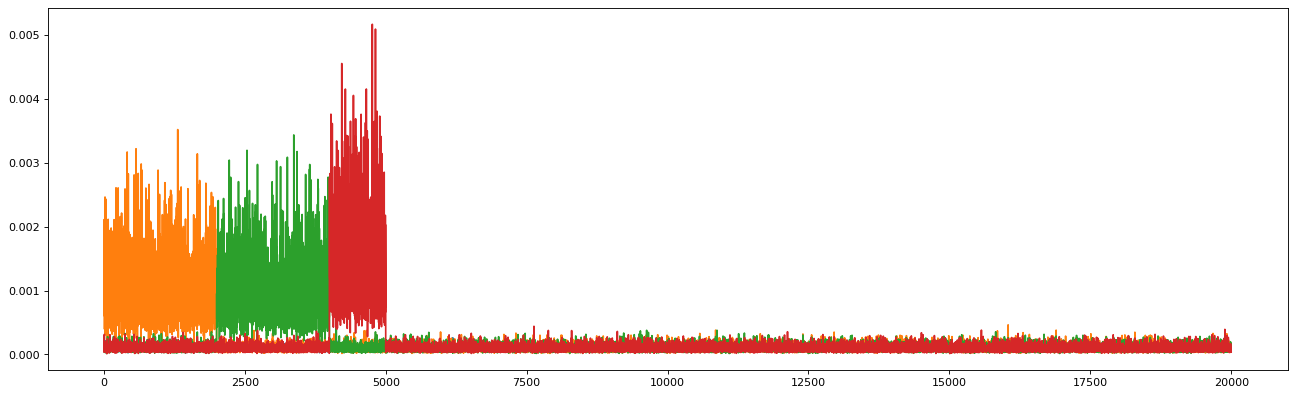

In [155]:
flattenedData
pyplot.clf()
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(flattenedData)

In [ ]:
print("test nullLikelihoods.prod(1)", nullLikelihoods.prod(1))
# case1null = nullLikelihoods[:, 0]
# case2null = nullLikelihoods[:, 1]
# caseBothNull = nullLikelihoods[:, 2]

# case1and2Null = case1null * case2null

# case1andBothNull = nullLikelihoods[:, 0] * caseBothNull
# case2andBothNull = nullLikelihoods[:, 1] * caseBothNull

In [ ]:
print("empirical rr for both", afsFlatPooled[4000:5000, 3].mean()/ afsFlatPooled[0:4000, 3].mean())
print("empirical rr for 1", afsFlatPooled[0:2000, 1].mean()/ afsFlatPooled[2000:4000, 1].mean())
print("empirical rr for 2", afsFlatPooled[2000:4000, 2].mean()/ afsFlatPooled[:2000, 2].mean())
print("nullLikelihoodGlobal 1", nullLikelihoodsGlobal[0:2000, 0].mean(), nullLikelihoodsGlobal[2000:, 0].mean())
print("nullLikelihoodGlobal 2", nullLikelihoodsGlobal[2000:4000, 1].mean(), nullLikelihoodsGlobal[4000:, 1].mean())
print("nullLikelihoodGlobal Both", nullLikelihoodsGlobal[4000:5000, 2].mean(), nullLikelihoodsGlobal[0:4000, 2].mean())

In [ ]:
altCountsByGenePooledCtrls[:, :, :].sum([1,2])

In [ ]:
altCountsByGenePooledCtrls[:, :, :]

In [ ]:
randomDist = Uniform(0, 1)
randomDist2 = Uniform(1, 10000)
fnArgs = []
# pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
# P(V|D) * P(D) / P(V)
nGenes = len(altCountsByGenePooledCtrls)

probs = randomDist.sample([3,])
probs = probs / probs.sum()
print(probs)
    #pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth
fnArgs = [*probs, *randomDist2.sample([4,])]
fnArgs

In [ ]:
llPooledBivariateSingleGene(tensor([10.,1.,1.,20000.]), tensor([.01,.01,.05]), tensor(13.), tensor(10.), tensor(10.), tensor(100000.), tensor(.77), tensor(.1), tensor(.1), tensor(.01))

In [ ]:
#this gives -2.401 log(likelihoodUnivariateSingleGene(xCtrl = 10, xCase1 = 1, prevalence1 = .01, pi0 = .9, pi1 = .1, pDiseaseGivenVariant = .001))
#tensor(-2.5290): llUnivariateSingleGeneJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
r = llUnivariateSingleGeneNoJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
assert(abs(-r + tensor(-2.4010)) < .1)

In [ ]:
altCounts = tensor([10., 2., 3., 1.])
n = altCounts.sum()

testAlpha = tensor([16., 20., 30., 15.])
print(f"test data: testAlpha: {testAlpha}, n: {n}, altCounts: {altCounts}")
DirichletMultinomial(total_count=n, concentration=testAlpha).log_prob(altCounts)

In [ ]:
pDgivenV(.01, afsByGene[0:2000, 0, 1], 1e-4).mean()

In [ ]:
### Test functions
pDgivenV(.01, afsByGeneRR2[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).mean()

In [ ]:
# variance is wrong
def betaVariance(alpha, beta):
    return (alpha * beta) / ( ((alpha + beta)**2) + (alpha + beta + 1) )

def betaMean(alpha, beta):
    return alpha / (alpha + beta)

print("variance", betaVariance(6.47e1,5.39e3))
print("mean", betaMean(6.47e1,5.39e3))
print("true varianc", )

In [ ]:
m1 = afsByGene[0:2000, 0, 1].mean()
m2 = afsByGeneRR2[0:2000, 0, 1].mean()/afsByGeneRR2[2000:, 0, 1].mean()
m1 - m2
print(m1, m2)

In [ ]:
start = time.time()
res = fitFnUniveriate(altCountsByGene, pDs, nEpochs=20, minLLThresholdCount=20, debug=True)
print((time.time() - start) / 20, "per iteration")
res

In [ ]:
fitFnUniveriate(altCountsByGeneRR2, pDs)

In [ ]:
pDgivenV(pDs[0], afsByGeneRR2Shape5[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).std()

In [ ]:
pDgivenV?

In [ ]:
fitFnUniveriate(altCountsByGeneRR2, pDs, debug=True)

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2, pDs, debug=True)

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, debug=True)

In [ ]:
Beta(2.23307950e+02, 2.52700651e+04).sample([10_000,]).mean()

In [ ]:
Beta(2.20865706e+02, 1.73544747e+04).sample([10_000,]).std()

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR3, pDs, nEpochs=50)

In [ ]:
Beta(2.50432693e+02, 1.87756988e+04).sample([10_000]).mean()

In [ ]:
fitFnUniveriate(altCountsByGeneRR3, pDs, nEpochs=50)

In [ ]:
Beta(3.84376856e+02, 2.37879954e+04).sample([10_000]).mean()

In [ ]:
resultsRR2Shape5 = []
for i in range(1):
    res = fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)
    resultsRR2Shape5.append(res)

In [ ]:
resultsRR2Shape5

In [ ]:
Beta(1.96912591e+02, 1.61461738e+04).sample([10000,]).mean()

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=50, minLLThresholdCount=50, debug=False)

In [ ]:
Beta(3.30289057e+03, 2.94460355e+04).sample([10000,]).mean()

In [ ]:
# doesn't really work resConstrained = fitFnUniveriateBetaBinomialConstrained(altCountsByGeneRR2Shape5, pDs, nEpochs=10, minLLThresholdCount=10, debug=True)
#resConstrained

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=10, minLLThresholdCount=10, debug=False)

In [ ]:
cachedData

In [149]:
# params = {"lls": [], "inferredAlphas": [], "inferredPis": [], "inferredPDVs": [], "trueMeanPDVs": [], "truePis": []}
# cachedData = [[altCountsByGenePooledCtrls, afsByGenePooledCtrls, {
#             "nCases": nCasesLarge,
#             "nCtrls": nCtrlsLarge,
#             "pDs": pDsLarge,
#             "diseaseFractions": diseaseFractions,
#             "rrShape": rrShape,
#             "rrMeans": rrMeans,
#             "afShape": afShape,
#             "afMean": afMean
#         }]]

In [ ]:
for i in range(10):
    if i >= len(cachedData):
        start = time.time()
        altCountsByGenePooledCtrls, afsByGenePooledCtrls = genDataSequentialPooledCtrls(nCases=nCasesLarge, nCtrls=nCtrlsLarge, pDs=pDsLarge, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
        print("took", time.time() - start)
        cachedData.append([altCountsByGenePooledCtrls, afsByGenePooledCtrls, {
            "nCases": nCasesLarge,
            "nCtrls": nCtrlsLarge,
            "pDs": pDsLarge,
            "diseaseFractions": diseaseFractions,
            "rrShape": rrShape,
            "rrMeans": rrMeans,
            "afShape": afShape,
            "afMean": afMean
        }])
        
    res = fitFnBivariate(cachedData[i][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=0)
    bestRes = res["params"][-1]

    inferredPis = tensor(bestRes[0:3])
    print("inferredPis", inferredPis)
    inferredAlphas = tensor(bestRes[3:])
    print("inferredAlphas", inferredAlphas)
    
    inferredPDs = Dirichlet(concentration=inferredAlphas).sample([10_000,]).mean(0)

    params["lls"].append(res["lls"][-1])
    params["inferredAlphas"].append(inferredAlphas)
    params["inferredPis"].append(inferredPis)
    params["inferredPDVs"].append(inferredPDs)

    truth1 = pDgivenV(pDsLarge[0], afsByGenePooledCtrls[0:2000, 0, 1], afsByGenePooledCtrls[0:2000, 0, 0]).mean()
    truth2 = pDgivenV(pDsLarge[1], afsByGenePooledCtrls[2000:4000, 1, 1], afsByGenePooledCtrls[2000:4000, 0, 0]).mean()
    truth3 = pDgivenV(pDsLarge[2], afsByGenePooledCtrls[4000:5000, 2, 1], afsByGenePooledCtrls[4000:5000, 0, 0]).mean()
    truth0 = 1 - (truth1 + truth2 + truth3)
    print("truth0", truth0, "truth1", truth1, "truth2", truth2, "truthBoth", truth3)

    params["trueMeanPDVs"].append(tensor([truth0, truth1, truth2, truth3]))
    params["truePis"].append(tensor(diseaseFractions))

    print(f"params on run {i}", params)

In [ ]:
params

In [ ]:
res = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=0)

In [ ]:
res1 = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=1)

In [ ]:
res2 = fitFnBivariate(cachedData[0][0], pDsLarge, nEpochs=20, minLLThresholdCount=20, debug=True, costFnIdx=2)

In [ ]:
print("res0", res0)
print("\nres0", "pis", res0["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res0["params"][-1][3:])).sample([10_000]).mean(0))

print("\n\n\nres1", res1)
print("\nres1", "pis", res1["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res1["params"][-1][3:])).sample([10_000]).mean(0))

print("\n\n\nres2", res2)
print("\nres2", "pis", res2["params"][-1][0:3], "mean P(D|V)'s", Dirichlet(tensor(res2["params"][-1][3:])).sample([10_000]).mean(0))

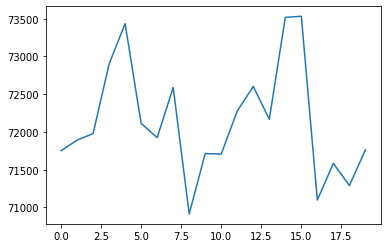

In [136]:
pyplot.plot(res0["llTrajectory"])



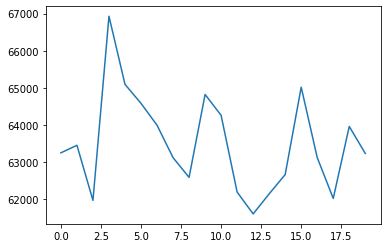

In [137]:
pyplot.plot(res1["llTrajectory"])

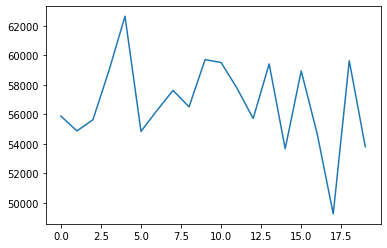

In [138]:
pyplot.plot(res2["llTrajectory"])

In [ ]:
params

In [ ]:
(afsByGenePooledCtrls[2000:4000, 1, 1]/afsByGenePooledCtrls[2000:4000, 0, 0]).mean()

In [ ]:
truth = pDgivenV(pD., afsByGenePooledCtrls[0:2000, :, 1], afsByGenePooledCtrls[0:2000, 0, 0])

In [ ]:
test = Dirichlet(tensor(1/4.0).expand(4)).sample()
test = test[0:3]
r = [0,1,2,3]
r[0:4]

In [ ]:
fitFnBivariate(altCountsByGenePooledCtrls, pDs, nEpochs=100, minLLThresholdCount=100, debug=True)

In [ ]:
d = Dirichlet(concentration=tensor([1.40625703e+04,
         5.56195520e+03, 1.57978682e+02, 2.33518936e+04]))
d.sample([10_000,]).mean(0)

In [ ]:
Beta(7.74788652e+02, 2.58170768e+04 + 9.72956833e+02 + 5.18278100e+03).sample([10000]).mean()

In [ ]:
Beta(3.05871723e+04, 3.25256694e+02 + 3.75135881e+03 +4.52942294e+04).sample([10000,]).mean()

In [ ]:
start = time.time()
res = fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=100, minLLThresholdCount=100, debug=False)
print("fitFnUniveriateBetaBinomial took for 100 epochs: ", time.time() - start)

In [ ]:
pyplot.plot(res["llTrajectory"])
res

In [ ]:
binomH0 = Binomial(total_count=tensor([1.,1]), probs=pDs[0])

In [ ]:
binomH0.log_prob(tensor(1.))

In [ ]:
costFn2 = likelihoodUnivariateFast(altCountsByGene, pDs)
# print(costFn2([1e-9, .999999]))
print(costFn2([1e-9, 1e-9]))
print(costFn2([0.08845797,0.11094360])) #gives ~12067 using jensen's method, and ~9887 using exponentiation of the log

# best result from R
#  0.08845797           0.11094360 , ll -10127.23, and with jensen's version, "example -12037.4347455843"
# pDgivenV, pi1


In [ ]:
costFn = likelihoodUnivariate(altCountsByGene, pDs)
print("costFn1:", costFn([.001, .01]),"costFn2:",costFn2([.001, .01]))

In [ ]:
costFn([0.0001,0.11094360])

In [ ]:
print(costFn2([0.0001,0.11094360]))

In [ ]:
d = Binomial(total_count=tensor([14., 0., 9.]), probs=tensor(.0099))
d.log_prob(tensor([0.,0.,0.]))

In [ ]:
costFn2([1e-9, .999999])

In [ ]:
binomH0 = Binomial(total_count=geneSums, probs=.001)
binomH1 = Binomial(total_count=geneSums, probs=.01)
caseAltCounts = altCountsByGene[:, 0, 1]
print(caseAltCounts)
component0 = binomH0.log_prob(caseAltCounts)
print("component0", component0, .5*component0)
component1 = binomH1.log_prob(caseAltCounts)

In [ ]:
pDgivenV(pDs[0], afsByGene2[0:2000, 0, 1].mean(), afMean)

In [ ]:
condition1 = altCountsByGene2[:, 0, :]
condition1
pDs[0]

afsByGene2[0:2000,:,1].mean()

In [ ]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene2[:, 0, 1:2].flatten())
pyplot.plot(afsByGene2[:, 0, 0:1].flatten())

In [ ]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGenePooledCtrls[:, 0, 0:1].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 0, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 1, 1:2].flatten())
pyplot.plot(afsByGenePooledCtrls[:, 2, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 1:2].flatten())
# pyplot.plot(afsByGeneRR2[:, 0, 0:1].flatten())

In [ ]:
ctrlCounts = altCountsByGene[:, 0, 0]
altCountsCases = altCountsByGene[:, :, 1]

altCountsFlat = []
for geneIdx in range(nGenes):
    altCountsFlat.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1].flatten()])
altCountsFlat = tensor(altCountsFlat)

In [ ]:
altCountsFlat[0]

In [ ]:
DirichletMultinomial?

In [ ]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)

K = 4  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    alpha0 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha1 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha2 = pyro.sample('alpha0', Uniform(1, 2.5e4))
    alpha3 = pyro.sample('alpha0', Uniform(1, 2.5e4))

    with pyro.plate('components', K):
        concentrations = pyro.sample('concentrations', dist.Dirichlet(0.5 * torch.ones(K)))

    with pyro.plate('data', len(data)):
        # Local variables.
        component = pyro.sample('assignment', dist.Categorical(weights))
        print(f"concentrations: {concentrations[component]}")
        pyro.sample('obs', DirichletMultinomial(concentration=concentrations[component], total_count=data.sum(1)), obs=data)

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [ ]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "concentrations":
        return torch.ones(K) / K
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'concentrations']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, altCountsFlat)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(2))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

In [ ]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(altCountsFlat)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [148]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

NameError: name 'losses' is not defined

<Figure size 1000x300 with 0 Axes>

In [ ]:
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
map_estimates = global_guide(altCountsFlat)
weights = map_estimates['weights']
locs = map_estimates['concentrations']
print('weights = {}'.format(weights.data.numpy()))
print('concentrations = {}'.format(locs.data.numpy()))

In [ ]:
Dirichlet(tensor([0.8973397  , 0.0494441,  0.04917945, 0.00403667])).sample([10_000,]).mean()